In [30]:
!pip install tqdm

In [31]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./input"))

# Any results you write to the current directory are saved as output.

['images']


In [32]:
data_root = './input/images/'
print(os.listdir(data_root))

['test', 'train']


In [33]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

train_path = os.path.join(data_root, 'train')
train_dirs = os.listdir(train_path)
print(train_dirs)
# class_names = ['bp', 'notebook', 'tv']
class_names = train_dirs
print(len(class_names))

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    #source_dir = data_root + 'train' + '/' + class_name
    print(source_dir)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

['bp', 'cpu', 'gpu', 'hdd', 'notebook', 'tv']
6
./input/images/train\bp


100%|██████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1270.15it/s]


./input/images/train\cpu


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 614.74it/s]


./input/images/train\gpu


100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 896.50it/s]


./input/images/train\hdd


100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 964.26it/s]


./input/images/train\notebook


100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1366.20it/s]


./input/images/train\tv


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 682.94it/s]


In [34]:
!ls train

bp
cpu
gpu
hdd
notebook
tv


In [74]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
#     transforms.RandomResizedCrop(224),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
# val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [75]:
len(train_dataloader), len(train_dataset)

(25, 196)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


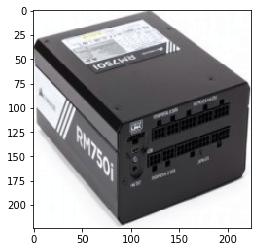

In [76]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

tensor(2)


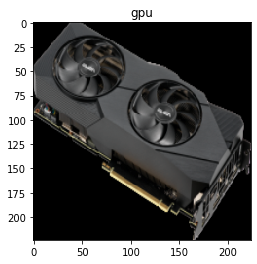

tensor(0)


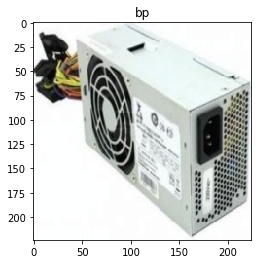

tensor(0)


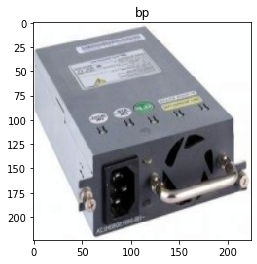

tensor(2)


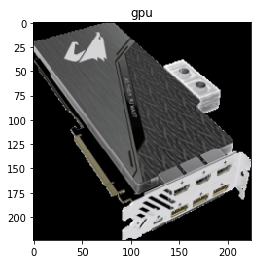

tensor(2)


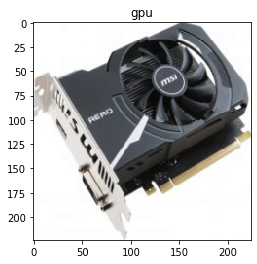

tensor(0)


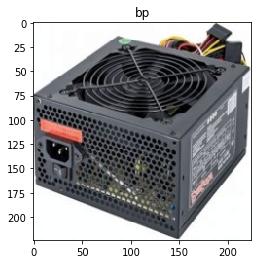

tensor(0)


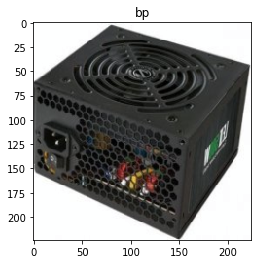

tensor(0)


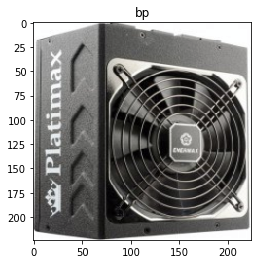

In [38]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    print(y_item)
    show_input(x_item, title=class_names[y_item])

In [45]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [48]:
model = models.resnet152(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, len(class_names))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [49]:
train_model(model, loss, optimizer, scheduler, num_epochs=10);

Epoch 0/9:


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:45<00:00,  4.21s/it]


train Loss: 1.1097 Acc: 0.6550


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.89s/it]


val Loss: 1.3810 Acc: 0.7708
Epoch 1/9:


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:45<00:00,  4.24s/it]


train Loss: 0.5999 Acc: 0.8050


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.90s/it]


val Loss: 0.9156 Acc: 0.8958
Epoch 2/9:


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:45<00:00,  4.21s/it]


train Loss: 0.3190 Acc: 0.9250


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.88s/it]


val Loss: 0.6869 Acc: 0.8958
Epoch 3/9:


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:46<00:00,  4.25s/it]


train Loss: 0.2438 Acc: 0.9450


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.91s/it]


val Loss: 0.4299 Acc: 0.8750
Epoch 4/9:


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:45<00:00,  4.21s/it]


train Loss: 0.1697 Acc: 0.9550


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.86s/it]


val Loss: 0.3915 Acc: 0.8542
Epoch 5/9:


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:47<00:00,  4.30s/it]


train Loss: 0.1573 Acc: 0.9650


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.86s/it]


val Loss: 0.4213 Acc: 0.8958
Epoch 6/9:


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:46<00:00,  4.27s/it]


train Loss: 0.1294 Acc: 0.9800


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.88s/it]


val Loss: 0.3785 Acc: 0.8958
Epoch 7/9:


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:45<00:00,  4.24s/it]


train Loss: 0.1410 Acc: 0.9700


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.86s/it]


val Loss: 0.4004 Acc: 0.8958
Epoch 8/9:


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:58<00:00,  4.73s/it]


train Loss: 0.1817 Acc: 0.9500


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.90s/it]


val Loss: 0.3609 Acc: 0.8958
Epoch 9/9:


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:45<00:00,  4.23s/it]


train Loss: 0.1566 Acc: 0.9850


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.89s/it]


val Loss: 0.3640 Acc: 0.8958


In [50]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test\\unknown'

In [51]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths(test_dir, val_transforms)

# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [79]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
#     print(preds)
#     print(preds.argmax(dim=1))
#     test_predictions.append(torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_predictions.append(preds.argmax(dim=1))
#     test_predictions.append(torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
#     print(test_predictions)
    
# test_predictions = np.concatenate(test_predictions)
test_predictions = np.concatenate(test_predictions)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.48s/it]


['bp', 'cpu', 'gpu', 'hdd', 'notebook', 'tv']


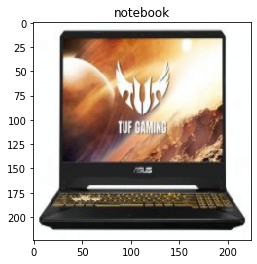

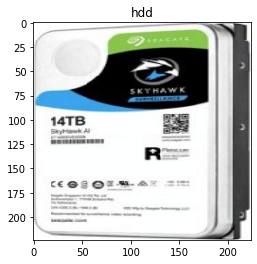

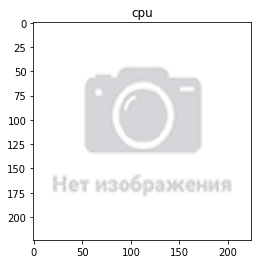

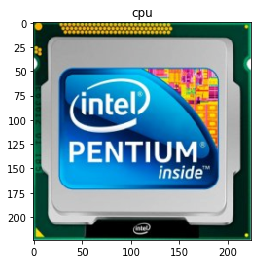

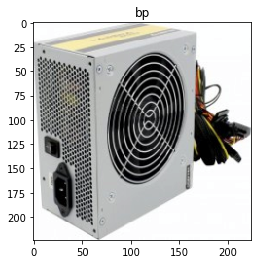

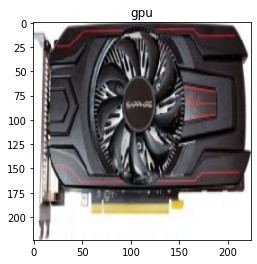

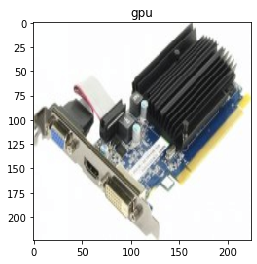

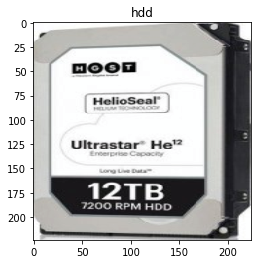

In [80]:
print(class_names)

inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=class_names[pred])
#     show_input(img, title=pred)

In [17]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [18]:
submission_df['label'] = submission_df['label'].map(lambda pred: class_names[pred])
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
test\unknown\unknown\1031162,notebook
test\unknown\unknown\268884,bp
test\unknown\unknown\369690,bp
test\unknown\unknown\448189,bp
test\unknown\unknown\682166,notebook
test\unknown\unknown\794816,notebook


In [19]:
submission_df.to_csv('submission.csv')

In [20]:
!rm -rf train val test